In [60]:
import pandas as pd
import requests
from matplotlib import pyplot as plt
import os
import shutil
import time

In [63]:
player = 'simonr0204'

In [64]:
#Set up results directories
cwd = os.getcwd()    
destination = os.path.join(cwd, player) 
if not os.path.exists(destination):
    os.makedirs(destination)
else:
    shutil.rmtree(destination)           
    os.makedirs(destination) 

In [65]:
def get_matches(playername, n):

    with open('API_KEY.txt', 'r') as keyfile:
            api_key = keyfile.read()               #Your API key goes here

    def get_match_IDS(playername):    #Gets the match IDS for the last 14 days for player specified

            url = "https://api.pubg.com/shards/steam/players?filter[playerNames]="+playername          
            header = {
              "Authorization": "Bearer "+api_key,
              "Accept": "application/vnd.api+json"
            }

            response = requests.get(url, headers=header).json()
            matchIDS = [response['data'][0]['relationships']['matches']['data'][i]['id'] for i,_ in enumerate(response['data'][0]['relationships']['matches']['data'])]
            return matchIDS

    def get_match_data(match_ID):    #Gets the match data for the match ID provided
            url = "https://api.pubg.com/shards/steam/matches/"+match_ID       
            header = {
              "Authorization": "Bearer "+api_key,
              "Accept": "application/vnd.api+json"
            }

            response = requests.get(url, headers=header).json()
            
            match_metadata = response['data']['attributes']
            
            participants = [ob for ob in response['included'] if ob['type']=='participant']
            for player in participants:
                if player['attributes']['stats']['name']==playername:
                    match_playerdata = (player['attributes']['stats'])
            
            return match_metadata, match_playerdata  #TO DO :replace 'playerdata' with actual player stats and concat with match metadata
                    

    matchIDS = get_match_IDS(playername)
    if n=='all':
        n=len(matchIDS)
    else:
        n = min(n, len(matchIDS)+1)
    print(f'Fetching match data for {playername} (= {n} matches)')
    matches_metadata=[]
    matches_playerdata=[]
    for match_ID in matchIDS[:n]:
        match_metadata, match_playerdata = get_match_data(match_ID)
        matches_metadata.append(match_metadata)
        matches_playerdata.append(match_playerdata)
    print('done')
    return pd.concat([pd.DataFrame(matches_metadata)[['createdAt', 'gameMode', 'mapName']], pd.DataFrame(matches_playerdata)], axis=1)

In [66]:
matches = get_matches(player ,'all')

Fetching match data for simonr0204 (= 143 matches)
done


In [68]:
matches.head()

,createdAt,gameMode,mapName,DBNOs,assists,boosts,damageDealt,deathType,headshotKills,heals,...,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,winPoints,winPointsDelta
0,2019-01-18T19:02:17Z,solo-fpp,Desert_Main,0,0,2,34.997932,byplayer,0,0,...,0,0.0,0,1540.754,0,1628.352660,3,14,0,0
1,2019-01-17T23:59:25Z,duo-fpp,Erangel_Main,0,0,0,0.000000,byplayer,0,0,...,0,0.0,0,698.650,0,946.356567,1,24,0,0
2,2019-01-17T23:51:41Z,duo-fpp,Desert_Main,1,0,0,199.999985,suicide,0,1,...,0,0.0,1,348.012,0,384.515200,3,32,0,0
3,2019-01-17T23:44:39Z,duo-fpp,Erangel_Main,0,0,0,0.000000,byplayer,0,0,...,0,0.0,0,292.947,0,273.825317,1,38,0,0
4,2019-01-17T23:37:59Z,duo-fpp,DihorOtok_Main,0,0,0,0.000000,byplayer,0,0,...,0,0.0,0,278.213,0,388.973236,3,40,0,0


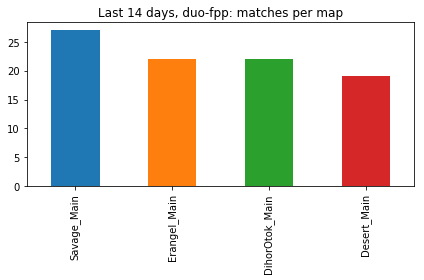

In [69]:
matches[matches['gameMode']=='duo-fpp']['mapName'].value_counts().plot(kind='bar')
plt.title('Last 14 days, duo-fpp: matches per map')
plt.tight_layout()
plt.savefig('maps.jpg')

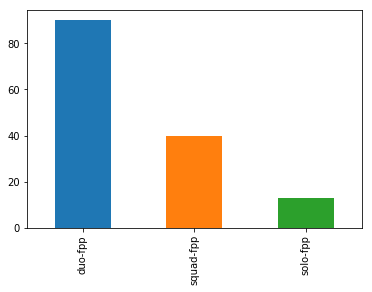

In [70]:
matches['gameMode'].value_counts().plot(kind='bar')